### The CHB-MIT dataset1, consists of records from 23 patients; with one case (chb21) taken from the same patient (chb01) 1.5 years later. The dataset was collected by investigators at the Children’s Hospital Boston and Massachusetts Institute of Technology (MIT). The median length of collection was for 36 hours with small gaps between records each hour due to hardware limitations.


#### Importing Libraries

In [58]:
!pip install matplotlib pandas numpy scipy seaborn mne
!pip install beautifulsoup4 requests wget
!pip install h5py tables kaggle
!pip install wfdb pyEDFlib

  Using cached tables-3.9.2.tar.gz (4.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [13 lines of output]
      cpuinfo failed, assuming no CPU features: 'flags'
      * Using Python 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:35:41)
      * Found cython 3.0.12
      * USE_PKGCONFIG: False
      * Found conda env: ``/opt/anaconda3/envs/datascience``
      /var/folders/fd/tf9m44dj0tvfhkp_rp0b4p040000gn/T/H5closeyi1rzmmp.c:1:10: fatal error: 'H5public.h' file not found
      #include "H5public.h"
               ^~~~~~~~~~~~
      1 error generated.
      .. ERROR:: Could not find a local HDF5 installation.
         You may need to explicitly state where your local HDF5 headers and
         library can be found by setting the ``HDF5_DIR`` environment
         variable or by using the ``--hdf5`` comma

In [60]:
import glob            # for file locations
import pprint          # for pretty printing
import re

pp = pprint.PrettyPrinter()

def file_list(folder_path, output=False):
    # create an empty list
    file_list = []
    # for file name in the folder path...
    for filename in glob.glob(folder_path):
        # ... append it to the list
        file_list.append(filename)
        
    # sort alphabetically
    file_list.sort()
    
    # Output
    if output:
        print(str(len(file_list)) + " files found")
        pp.pprint(file_list)
    
    return file_list

In [81]:
import wfdb 

dbs = wfdb.get_dbs()

records_list = wfdb.io.get_record_list('chbmit', records='all')
records_list[:5]

['chb01/chb01_01.edf',
 'chb01/chb01_02.edf',
 'chb01/chb01_03.edf',
 'chb01/chb01_04.edf',
 'chb01/chb01_05.edf']

In [82]:
part_codes = sorted(list(set([record.split('/')[0] for record in records_list])))
part_codes

['chb01',
 'chb02',
 'chb03',
 'chb04',
 'chb05',
 'chb06',
 'chb07',
 'chb08',
 'chb09',
 'chb10',
 'chb11',
 'chb12',
 'chb13',
 'chb14',
 'chb15',
 'chb16',
 'chb17',
 'chb18',
 'chb19',
 'chb20',
 'chb21',
 'chb22',
 'chb23',
 'chb24']

In [64]:
import os
from urllib.request import urlretrieve

def get_content(part_code):
  url = "https://physionet.org/physiobank/database/chbmit/"+part_code+'/'+part_code+'-summary.txt'
  filename = "./chbmit.txt"

  urlretrieve(url,filename)

  # read the file into a list
  with open(filename, encoding='UTF-8') as f:
      # read all the document into a list of strings (each line a new string)
      content = f.readlines()
      os.remove(filename)

  return content

get_content(part_codes[0])

['Data Sampling Rate: 256 Hz\n',
 '*************************\n',
 '\n',
 'Channels in EDF Files:\n',
 '**********************\n',
 'Channel 1: FP1-F7\n',
 'Channel 2: F7-T7\n',
 'Channel 3: T7-P7\n',
 'Channel 4: P7-O1\n',
 'Channel 5: FP1-F3\n',
 'Channel 6: F3-C3\n',
 'Channel 7: C3-P3\n',
 'Channel 8: P3-O1\n',
 'Channel 9: FP2-F4\n',
 'Channel 10: F4-C4\n',
 'Channel 11: C4-P4\n',
 'Channel 12: P4-O2\n',
 'Channel 13: FP2-F8\n',
 'Channel 14: F8-T8\n',
 'Channel 15: T8-P8\n',
 'Channel 16: P8-O2\n',
 'Channel 17: FZ-CZ\n',
 'Channel 18: CZ-PZ\n',
 'Channel 19: P7-T7\n',
 'Channel 20: T7-FT9\n',
 'Channel 21: FT9-FT10\n',
 'Channel 22: FT10-T8\n',
 'Channel 23: T8-P8\n',
 '\n',
 'File Name: chb01_01.edf\n',
 'File Start Time: 11:42:54\n',
 'File End Time: 12:42:54\n',
 'Number of Seizures in File: 0\n',
 '\n',
 'File Name: chb01_02.edf\n',
 'File Start Time: 12:42:57\n',
 'File End Time: 13:42:57\n',
 'Number of Seizures in File: 0\n',
 '\n',
 'File Name: chb01_03.edf\n',
 'File Sta

In [65]:
import re
part_info_dict = {}

def info_dict(content):
  
  line_nos=len(content)
  line_no=1

  channels = []
  file_name = []
  file_info_dict={}

  for line in content:

    # if there is Channel in the line...
    if re.findall('Channel \d+', line):
      # split the line into channel number and channel reference
      channel = line.split(': ')
      # get the channel reference and remove any new lines
      channel = channel[-1].replace("\n", "")
      # put into the channel list
      channels.append(channel)

    # if the line is the file name
    elif re.findall('File Name', line):
      # if there is already a file_name
      if file_name:
        # flush the current file info to it
        part_info_dict[file_name] = file_info_dict

      # get the file name
      file_name = re.findall('\w+\d+_\d+|\w+\d+\w+_\d+', line)[0]

      file_info_dict = {}
      # put the channel list in the file info dict and remove duplicates
      file_info_dict['Channels'] = list(set(channels))
      # reset the rest of the options
      file_info_dict['Start Time'] = ''
      file_info_dict['End Time'] = ''
      file_info_dict['Seizures Window'] = []

    # if the line is about the file start time
    elif re.findall('File Start Time', line):
      # get the start time
      file_info_dict['Start Time'] = re.findall('\d+:\d+:\d+', line)[0]

    # if the line is about the file end time
    elif re.findall('File End Time', line):
      # get the start time
      file_info_dict['End Time'] = re.findall('\d+:\d+:\d+', line)[0]

    elif re.findall('Seizure Start Time|Seizure End Time|Seizure \d+ Start Time|Seizure \d+ End Time', line):
      file_info_dict['Seizures Window'].append(int(re.findall('\d+', line)[-1]))

    # if last line in the list...
    if line_no == line_nos:
      # flush the file info to it
      part_info_dict[file_name] = file_info_dict

    line_no+=1
    
        
for part_code in part_codes:
  content = get_content(part_code)
  info_dict(content)


print(color.BOLD+color.UNDERLINE+'part_info_dict'+color.END)
display(part_info_dict['chb01_18'])
print(color.UNDERLINE+'\nPart Keys'+color.END)
print(part_info_dict[list(part_info_dict.keys())[0]].keys())

part_info_dict


{'Channels': ['F8-T8',
  'FZ-CZ',
  'T7-FT9',
  'P8-O2',
  'F7-T7',
  'F3-C3',
  'C4-P4',
  'P7-O1',
  'P4-O2',
  'P3-O1',
  'P7-T7',
  'FP1-F3',
  'F4-C4',
  'CZ-PZ',
  'FT10-T8',
  'FP2-F4',
  'C3-P3',
  'T7-P7',
  'FP1-F7',
  'FP2-F8',
  'FT9-FT10',
  'T8-P8'],
 'Start Time': '04:45:06',
 'End Time': '5:45:06',
 'Seizures Window': [1720, 1810]}


Part Keys
dict_keys(['Channels', 'Start Time', 'End Time', 'Seizures Window'])


In [66]:
import pandas as pd     # dataframes
import re

all_channels = []

for key in part_info_dict.keys():
    all_channels.extend(part_info_dict[key]['Channels'])
    
# turn the list into a pandas series
all_channels = pd.Series(all_channels)

# count how many times the channels appear in each participant
channel_counts = all_channels.value_counts()
channel_counts

F8-T8        675
F4-C4        675
T8-P8        675
FP2-F8       675
FP1-F7       675
            ... 
P7            13
FP2           13
EKG1-CHIN     13
01            13
LOC-ROC       11
Name: count, Length: 87, dtype: int64

In [67]:
threshold = len(part_info_dict.keys())
channel_keeps = list(channel_counts[channel_counts >= threshold].index)
channel_keeps

['F8-T8',
 'F4-C4',
 'T8-P8',
 'FP2-F8',
 'FP1-F7',
 'T7-P7',
 'C3-P3',
 'FP2-F4',
 'CZ-PZ',
 'FP1-F3',
 'P3-O1',
 'P4-O2',
 'P7-O1',
 'C4-P4',
 'F3-C3',
 'F7-T7',
 'P8-O2',
 'FZ-CZ']

### Loading the data

In [83]:
EXAMPLE_FILE = records_list[17]
EXAMPLE_ID = EXAMPLE_FILE.split('/')[1].split('.')[0]
EXAMPLE_ID

'chb01_18'

In [69]:
%%time
import pandas as pd
import numpy as np
import pyedflib

def data_load(file, selected_channels=[]):

  try: 
    url = "https://physionet.org/physiobank/database/chbmit/"+file
    filename = "./chbmit.edf"

    urlretrieve(url,filename)
    # use the reader to get an EdfReader file
    f = pyedflib.EdfReader(filename)
    os.remove(filename)
    
    # get a list of the EEG channels
    if len(selected_channels) == 0:
      selected_channels = f.getSignalLabels()

    # get the names of the signals
    channel_names = f.getSignalLabels()
    # get the sampling frequencies of each signal
    channel_freq = f.getSampleFrequencies()

    # make an empty file of 0's
    sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
    # for each of the channels in the selected channels
    for i, channel in enumerate(selected_channels):
      # add the channel data into the array
      sigbufs[:, i] = f.readSignal(channel_names.index(channel))
    
    # turn to a pandas df and save a little space
    df = pd.DataFrame(sigbufs, columns = selected_channels).astype('float32')
    
    # get equally increasing numbers upto the length of the data depending
    # on the length of the data divided by the sampling frequency
    index_increase = np.linspace(0,
                                 len(df)/channel_freq[0],
                                 len(df), endpoint=False)

    # round these to the lowest nearest decimal to get the seconds
    seconds = np.floor(index_increase).astype('uint16')

    # make a column the timestamp
    df['Time'] = seconds

    # make the time stamp the index
    df = df.set_index('Time')

    # name the columns as channel
    df.columns.name = 'Channel'

    return df, channel_freq[0]

  except:
    OSError
    return pd.DataFrame(), None


raw_data, freq = data_load(EXAMPLE_FILE, channel_keeps)
display(raw_data.head())

Channel,F8-T8,F4-C4,T8-P8,FP2-F8,FP1-F7,T7-P7,C3-P3,FP2-F4,CZ-PZ,FP1-F3,P3-O1,P4-O2,P7-O1,C4-P4,F3-C3,F7-T7,P8-O2,FZ-CZ
Time,,,,,,,,,,,,,,,,,,
0,104.908424,25.982906,0.976801,-28.717949,35.360195,-6.837607,8.791209,50.598289,18.949940,51.770451,35.750916,-75.213676,16.214897,-116.630035,11.916972,63.492062,-192.429794,-44.346764
0,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360
0,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,-0.195360,0.195360,0.195360,0.195360,0.195360,-0.195360,0.195360,0.195360,-0.586081,0.195360
0,2.148962,0.195360,-0.195360,-1.758242,-0.195360,0.195360,-0.195360,0.195360,-1.758242,0.195360,0.195360,-2.930403,0.195360,-3.711844,0.195360,0.586081,-6.837607,-0.586081
0,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,1.758242,0.195360,0.195360,-1.758242,0.195360,1.367521,0.195360,0.195360,-0.195360,0.586081


CPU times: user 1.66 s, sys: 1.61 s, total: 3.27 s
Wall time: 2min 48s


### Plot data

In [84]:
# set mne to only output warnings
mne.set_log_level('WARNING')

def mne_object(data, freq):
  # create an mne info file with meta data about the EEG
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1])
  
  # data needs to be in volts rather than in microvolts
  data = data.apply(lambda x: x*1e-6)
  # transpose the data
  data_T = data.transpose()
  
  # create raw mne object
  raw = mne.io.RawArray(data_T, info)

  return raw


plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 70.,                # filters out high frequencies
    'show_scrollbars': False,
    'show': True
}


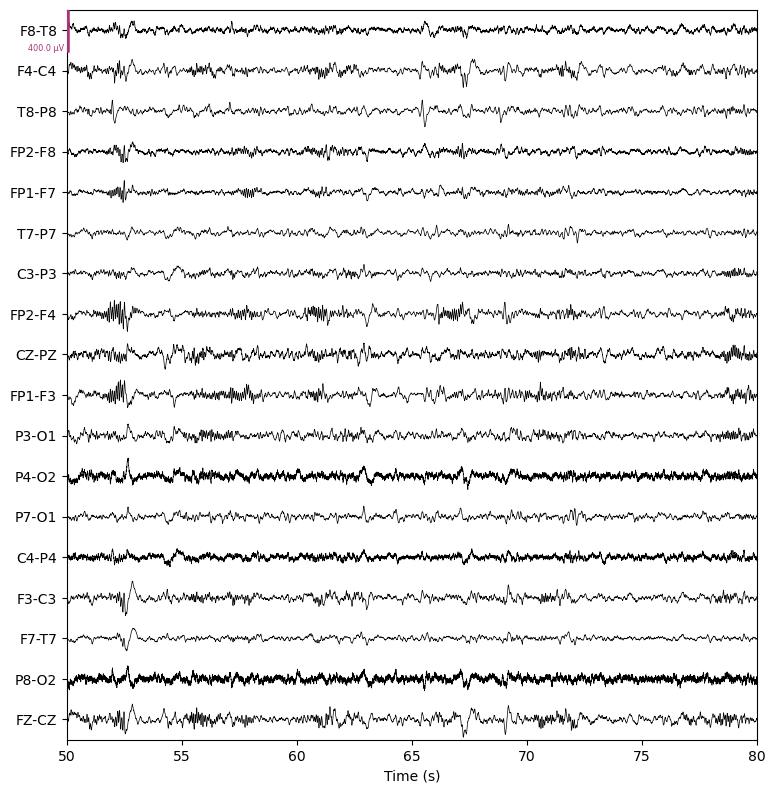

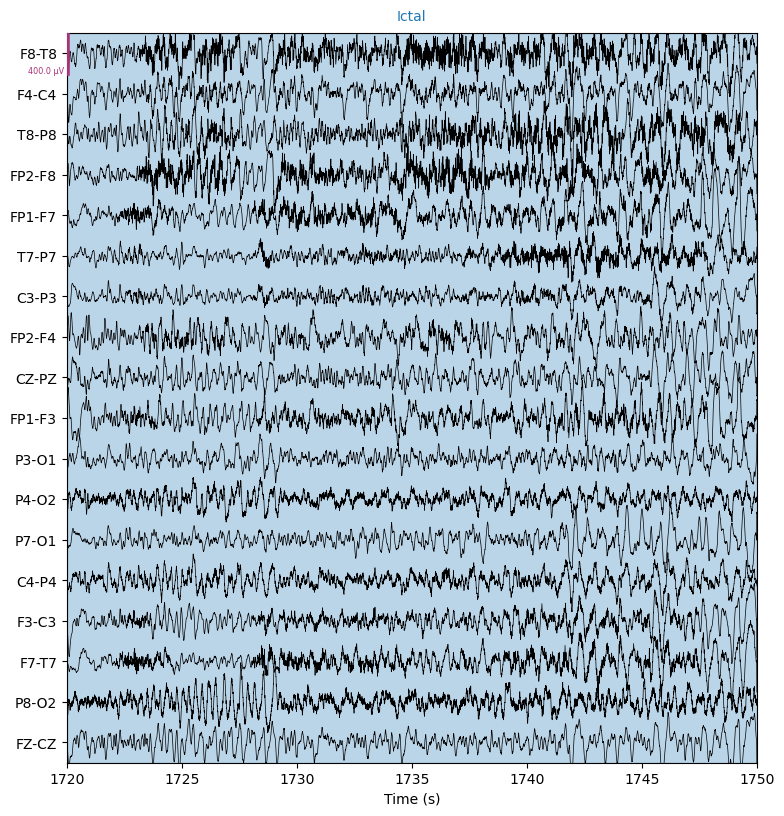

In [85]:
def mne_object(data, freq, events = None):
  # create an mne info file with meta data about the EEG
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1])
  
  # data needs to be in volts rather than in microvolts
  data = data.apply(lambda x: x*1e-6)
  # transpose the data
  data_T = data.transpose()
  
  # create raw mne object
  raw = mne.io.RawArray(data_T, info)

  if events:
    start_times = np.array(events[::2])
    end_times = np.array(events[1::2])
    anno_length = end_times-start_times
    event_name = np.array(['Ictal']*len(anno_length))

    raw.set_annotations(mne.Annotations(start_times,
                                      anno_length,
                                      event_name))

  return raw

mne_data = mne_object(raw_data, freq, part_info_dict[EXAMPLE_ID]['Seizures Window'])


mne_data.plot(start = 50, 
              duration = 30, **plot_kwargs);

seiz_start_time = part_info_dict[EXAMPLE_ID]['Seizures Window'][0]
mne_data.plot(start = seiz_start_time, 
              duration = 30, **plot_kwargs);

In [86]:
replace_dict = {}
drop_list = []
# for the channel names in the data...
for channel_name in mne_data.info['ch_names']:
    # get the name to change too
    name_change = re.findall('\w+',channel_name)[0].title()
    # check if it is already in the change list
    if name_change in list(replace_dict.values()):
        drop_list.append(channel_name)
    else:
        # if its not already there get the origional name and what we want to 
        # change it to
        replace_dict[channel_name] = name_change

# drop the ones that would be repeats
mne_data.drop_channels(drop_list)
# rename the channels
mne_data.rename_channels(replace_dict)
# set the standard montage
mne_data.set_montage('standard_1020')

<RawArray | 16 x 921600 (3600.0 s), ~112.5 MB, data loaded>

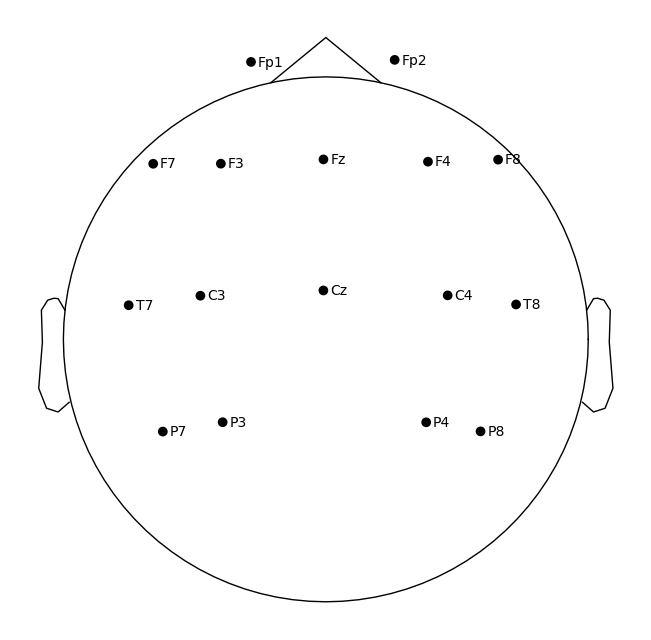

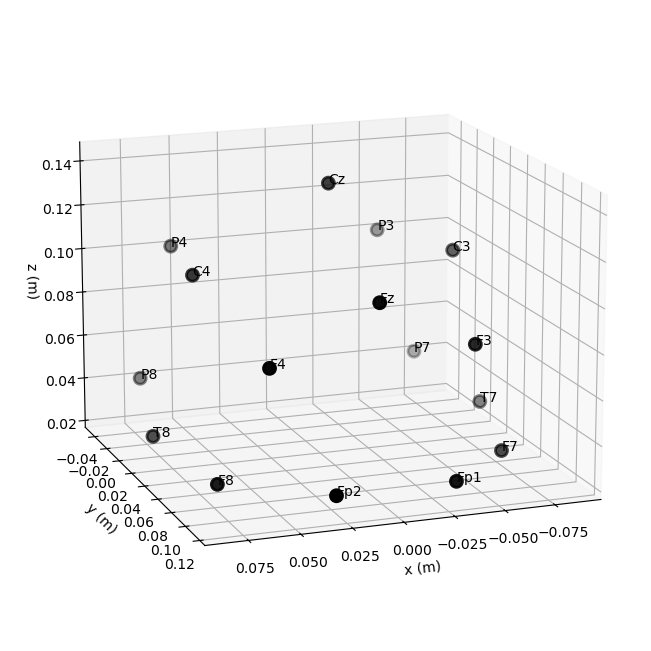

In [87]:
mne_data.plot_sensors(kind='topomap', show_names=True, to_sphere=True);
fig = mne_data.plot_sensors(kind='3d', show_names=True, show=False)
fig = fig.gca().view_init(azim=70, elev=15)
plt.show()

In [125]:
# file names for training and test data

files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path2pt+'/chb{}/*.edf'.format(l))


In [126]:
len(files_train), len(files_test)

(0, 0)

For a given EEG record, retrieve its known seizure windows

Compare each time point in the EEG data against the seizure intervals

Generate a boolean mask indicating seizure activity

Convert the mask into human-readable time intervals

In [99]:
def detect_seizures(eeg_data, seizure_windows, freq):
    """
    Detect seizure intervals in EEG data based on known seizure windows.
    
    Args:
        eeg_data (pd.DataFrame): EEG data with 'Time' as index
        seizure_windows (list): List of [start, end] seizure times in seconds
        freq (int): Sampling frequency of the EEG data
        
    Returns:
        tuple: (has_seizure (bool), seizure_intervals (list))
    """
    # Convert time index to seconds
    time_points = eeg_data.index.values
    
    # Create list to store seizure intervals
    seizure_mask = []
    
    # Check each time point against all seizure windows
    for t in time_points:
        in_seizure = False
        for window in seizure_windows:
            start, end = window
            if start <= t <= end:
                in_seizure = True
                break
        seizure_mask.append(in_seizure)
    
    # Create array of seizure intervals
    seizure_intervals = []
    if any(seizure_mask):
        current_start = None
        for i, (t, seizure) in enumerate(zip(time_points, seizure_mask)):
            if seizure and current_start is None:
                current_start = t
            elif not seizure and current_start is not None:
                seizure_intervals.append((current_start, time_points[i-1]))
                current_start = None
        if current_start is not None:
            seizure_intervals.append((current_start, time_points[-1]))
    
    return any(seizure_mask), seizure_intervals

# Usage example:
# Get seizure windows for the example file
seizure_windows = part_info_dict[EXAMPLE_ID]['Seizures Window']

# Reshape into list of intervals (if multiple seizures)
if len(seizure_windows) % 2 == 0:
    seizure_intervals = [seizure_windows[i:i+2] for i in range(0, len(seizure_windows), 2)]
else:
    seizure_intervals = [seizure_windows]  # Handle single seizure case

# Run detection
has_seizure, intervals = detect_seizures(raw_data, seizure_intervals, freq)

print(f"Seizure detected: {has_seizure}")
if has_seizure:
    print(f"Seizure intervals (seconds): {intervals}")

Seizure detected: True
Seizure intervals (seconds): [(1720, 1810)]


### Attempt using CNN

In [128]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

def create_cnn_model(input_shape, num_classes):
    """Create a 1D CNN model for seizure detection"""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Reshape((input_shape[0], input_shape[1], 1)),
        
        # Convolutional blocks
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def preprocess_data(raw_data, seizure_intervals, window_size=256, overlap=0.5):
    """
    Preprocess EEG data into labeled windows
    """
    X = []
    y = []
    data = raw_data.values
    time_points = raw_data.index.values
    
    # Create sliding windows
    step = int(window_size * (1 - overlap))
    for i in range(0, len(data) - window_size, step):
        window = data[i:i+window_size]
        time_window = time_points[i:i+window_size]
        
        # Check if any time in window contains seizure
        seizure_detected = any(
            any(start <= t <= end for t in time_window)
            for start, end in seizure_intervals
        )
        
        X.append(window)
        y.append(1 if seizure_detected else 0)
    
    return np.array(X), np.array(y)

# Example usage
# 1. Load and preprocess data
X, y = preprocess_data(raw_data, seizure_intervals)

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Create and train model
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_cnn_model(input_shape, num_classes=2)
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight={0: 1., 1: 5.})  # Adjust for class imbalance

# 4. Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

# 5. Prediction function
def predict_seizure(eeg_window, model, threshold=0.5):
    """Predict seizure probability for a single window"""
    prob = model.predict(eeg_window[np.newaxis, ...])[0][1]
    return prob > threshold, prob

# Print when seizure is detected
for i in range(len(X_test)):
    seizure_detected, prob = predict_seizure(X_test[i], model)
    if seizure_detected:
        print(f"Seizure detected in window {i} with probability {prob:.2f}")

# 6. Save model
model.save('seizure_detection_model.h5')


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.9263 - loss: 2.0039 - val_accuracy: 0.6293 - val_loss: 0.4353
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.9740 - loss: 0.1235 - val_accuracy: 0.8759 - val_loss: 0.5169
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.9869 - loss: 0.0641 - val_accuracy: 0.9470 - val_loss: 0.2340
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9603 - loss: 0.1261 - val_accuracy: 0.9653 - val_loss: 0.0539
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9789 - loss: 0.0793 - val_accuracy: 0.9974 - val_loss: 0.0156
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.9874 - loss: 0.0523 - val_accuracy: 0.9766 - val_loss: 0.0501
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9845 - loss: 0.0414 - val_accuracy: 0.9922 - val_loss: 0.0141
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.9760 - loss: 0.0841 - 

### Data simulation code

In [129]:
def real_time_processor(input_file, model):
    """Process pre-generated data in real-time pace"""
    df = pd.read_csv(input_file)
    
    buffer = []
    start_time = time.time()
    
    for idx, row in df.iterrows():
        # Maintain real-time pacing
        target_time = idx / 250  # 250Hz
        elapsed = time.time() - start_time
        if elapsed < target_time:
            time.sleep(target_time - elapsed)
            
        # Process sample
        buffer.append(row.values[:-1])  # Exclude time
        
        # Run detection every 5 second (250 samples)
        if idx % 250 == 0 and idx > 0:
            window = np.array(buffer[-250:])
            prediction = model.predict(window[np.newaxis, ...])
            if prediction[0][5] > 0.85:
                print(f"Seizure detected at {row['Time']:.1f}s")
                
# Usage: 
# 1. First generate the CSV instantly
fast_data_stream(records_list[17], 'streamed_data.csv', channel_keeps, 250)


Generated 921600 samples in 3686.4s simulation time


In [130]:
# For continuous prediction:
def real_time_processing(raw_data, model, window_size=256, overlap=0.5):
    """Generate predictions for continuous EEG stream"""
    predictions = []
    data = raw_data.values
    step = int(window_size * (1 - overlap))
    
    for i in range(0, len(data) - window_size, step):
        window = data[i:i+window_size]
        pred, prob = predict_seizure(window, model)
        predictions.append((i, pred, prob))
    
    return predictions

In [134]:
# show predictions results
predictions = real_time_processing(raw_data, model)
for idx, pred, prob in predictions:
    if pred:
        print(f"Seizure detected at index {idx} with probability {prob:.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

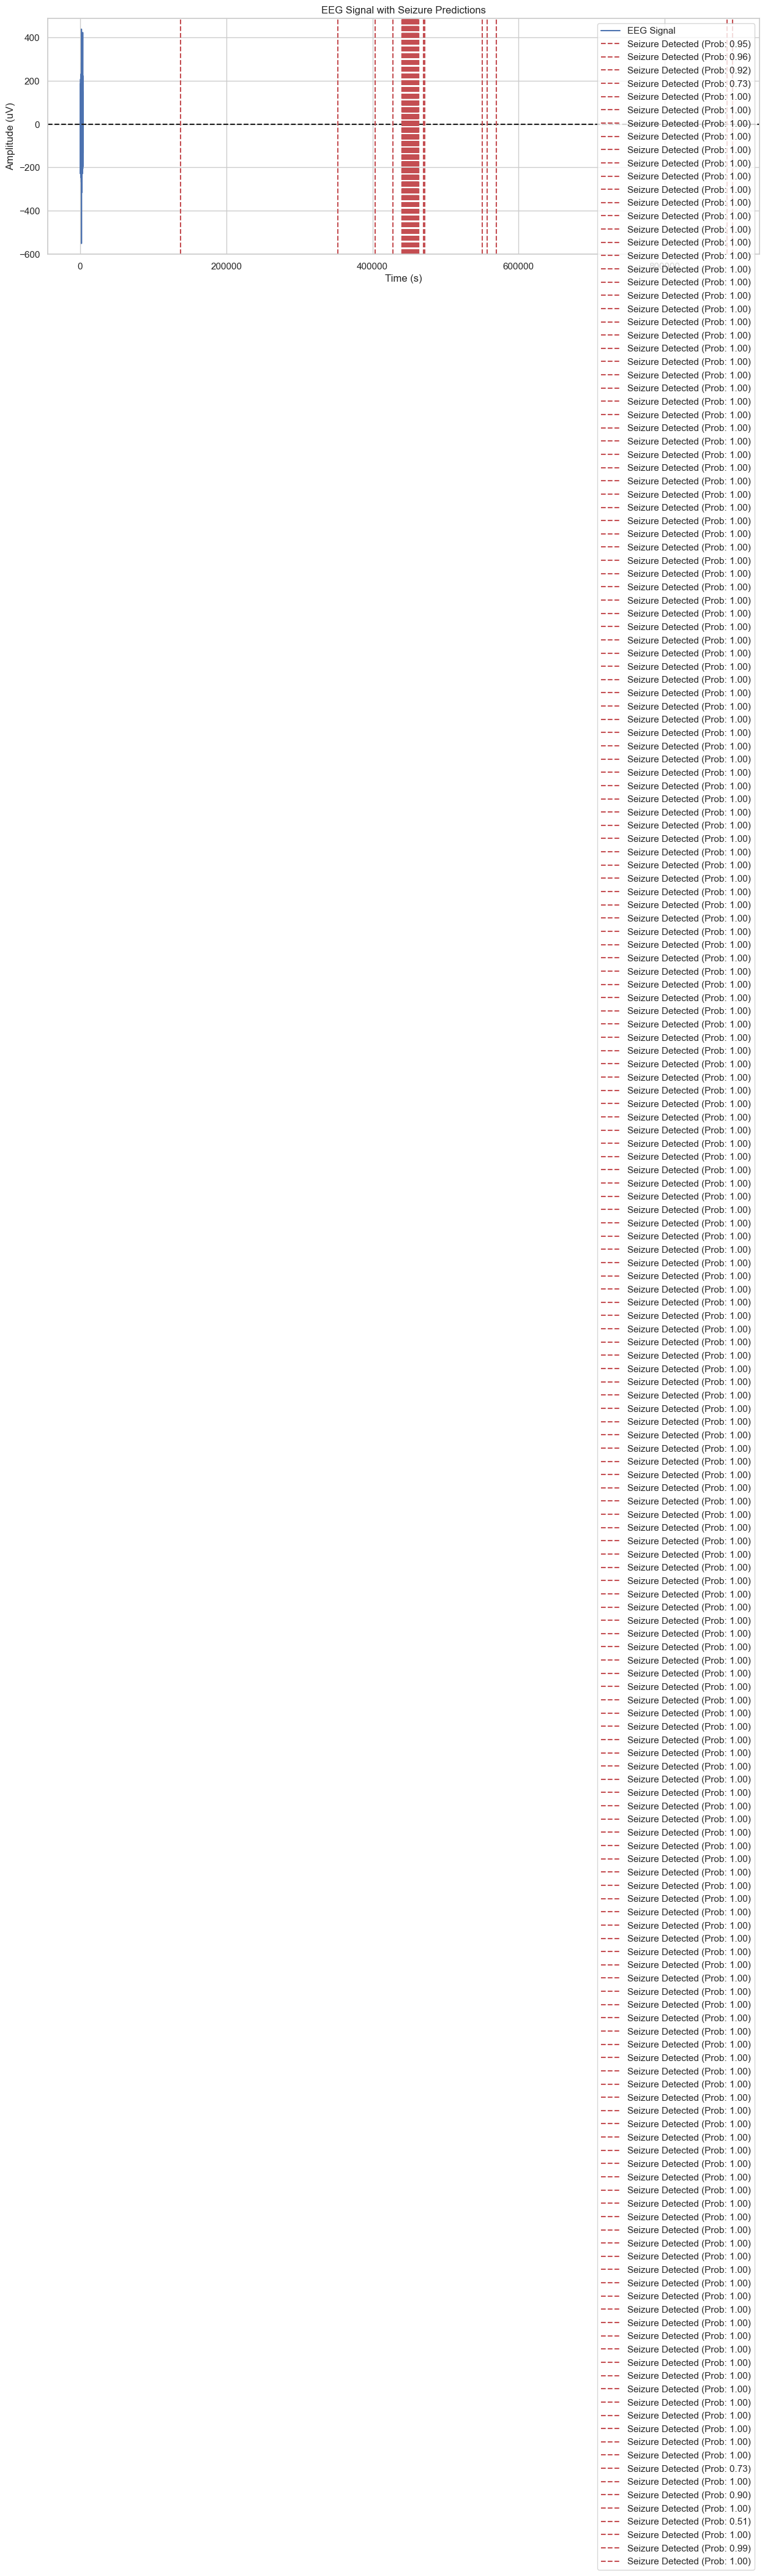

In [141]:
# visualize predictions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

plt.figure(figsize=(15, 5))
plt.plot(raw_data.index, raw_data.values[:, 0], label='EEG Signal')
plt.title('EEG Signal with Seizure Predictions')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.axhline(y=0, color='k', linestyle='--')
for idx, pred, prob in predictions:
    if pred:
        plt.axvline(x=idx, color='r', linestyle='--', label=f'Seizure Detected (Prob: {prob:.2f})')
plt.legend()
plt.show()

# save the plot
plt.savefig('seizure_detection_plot.png')


In [137]:
# 7. Load model
from tensorflow.keras.models import load_model
model = load_model('seizure_detection_model.h5')




45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1403
           1       0.90      0.95      0.92        37

    accuracy                           1.00      1440
   macro avg       0.95      0.97      0.96      1440
weighted avg       1.00      1.00      1.00      1440



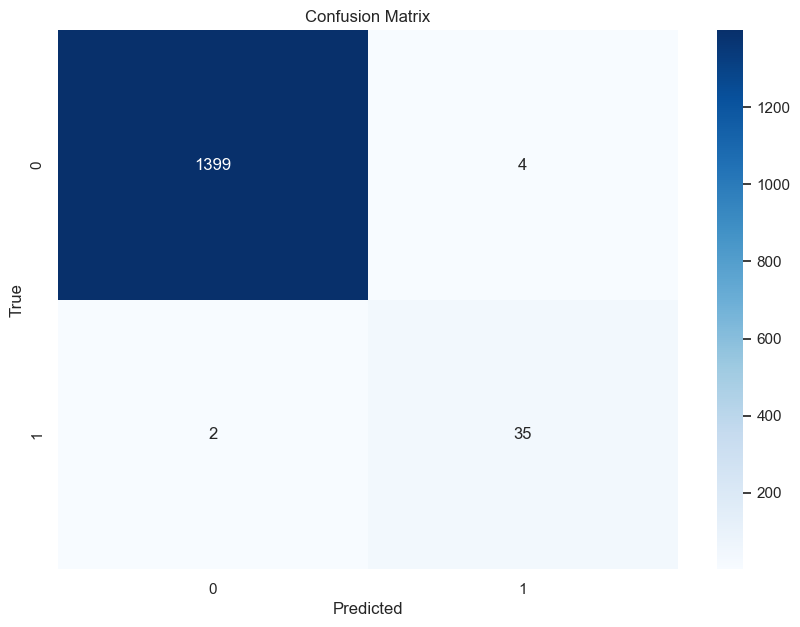

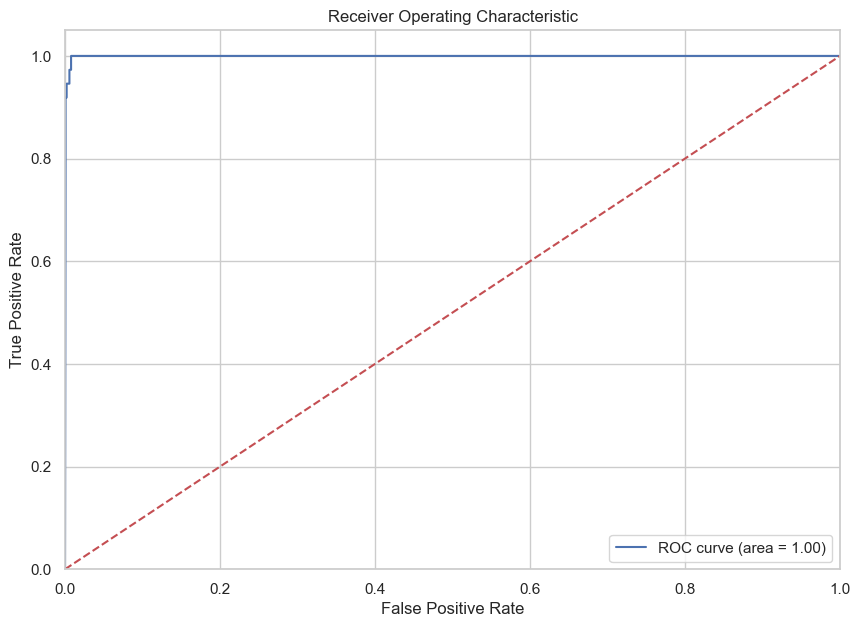

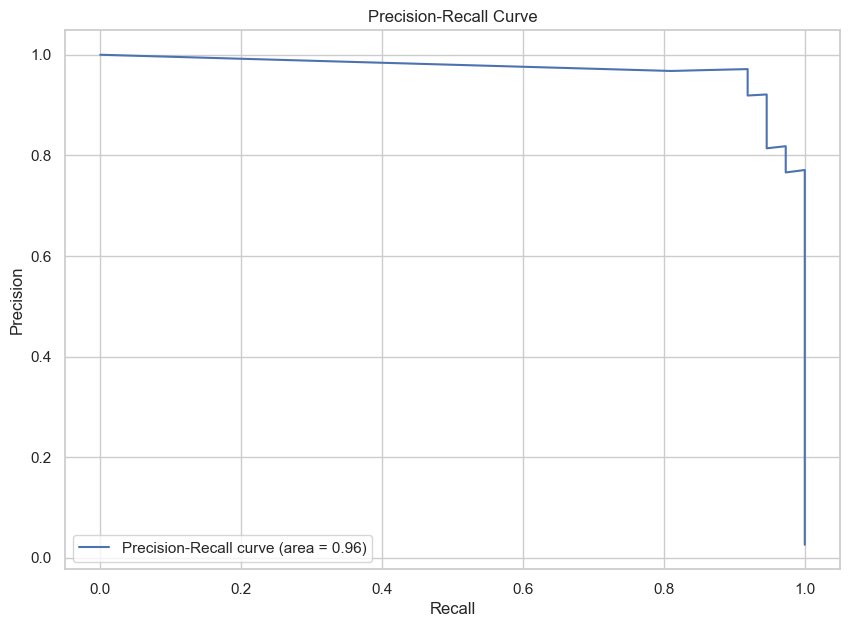

Accuracy: 1.00
F1 Score: 0.92
Recall: 0.95
Precision: 0.90
ROC AUC Score: 1.00
Mean Squared Error: 0.00
Mean Absolute Error: 0.00
R2 Score: 0.83
Mean Absolute Percentage Error: 12509998964918.04
Explained Variance Score: 0.83
Max Error: 1.00


In [138]:
# train and evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_absolute_error


# 1. Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

# 2. Classification Report
print(classification_report(y_true_classes, y_pred_classes))

# 3. Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 4. ROC Curve
fpr, tpr, thresholds = roc_curve(y_true_classes, y_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 5. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_classes, y_pred[:, 1])
average_precision = average_precision_score(y_true_classes, y_pred[:, 1])
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 6. Additional Metrics
print(f"Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.2f}")
print(f"F1 Score: {f1_score(y_true_classes, y_pred_classes):.2f}")
print(f"Recall: {recall_score(y_true_classes, y_pred_classes):.2f}")
print(f"Precision: {precision_score(y_true_classes, y_pred_classes):.2f}")
print(f"ROC AUC Score: {roc_auc_score(y_true_classes, y_pred[:, 1]):.2f}")
print(f"Mean Squared Error: {mean_squared_error(y_true_classes, y_pred_classes):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_true_classes, y_pred_classes):.2f}")
print(f"R2 Score: {r2_score(y_true_classes, y_pred_classes):.2f}")
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_true_classes, y_pred_classes):.2f}")
print(f"Explained Variance Score: {explained_variance_score(y_true_classes, y_pred_classes):.2f}")
print(f"Max Error: {max_error(y_true_classes, y_pred_classes):.2f}")


In [114]:
print(model.input_shape)  # Should show (None, window_size, num_channels, 1)

(None, 256, 18)


In [140]:
def real_time_processor(input_file, model, window_size=256):
    """Fixed-dimension processor"""
    df = pd.read_csv(input_file)
    num_channels = len(df.columns) - 1  # Exclude time column
    
    # Initialize buffer with zeros
    buffer = np.zeros((window_size, num_channels))
    
    for idx, row in df.iterrows():
        # Update buffer (FIFO)
        buffer = np.roll(buffer, -1, axis=0)
        buffer[-1] = row.values[:-1]  # Exclude time
        
        # Make predictions every 50ms (12.5 samples @250Hz)
        if idx % 5 == 0 and idx >= window_size:
            # Reshape to match model input (batch, time, channels, 1)
            input_data = buffer[np.newaxis, ..., np.newaxis]
            prediction = model.predict(input_data)
            
            if prediction[0][5] > 0.85:
                print(f"Seizure detected at {row['Time']:.1f}s")
            else:
                print(f"No seizure at {row['Time']:.1f}s")

In [152]:
import random
import time

def real_time_monitoring():
    while True:
        simulated_data = np.random.randn(1, len(raw_data.columns))
        prediction = model.predict(simulated_data)
        
        if prediction == 1:
            send_alert("Potential seizure detected! Location: " + get_location())
            trigger_ems()
        
        time.sleep(60)  # Check every minute

### Medication Tracking


In [153]:
medication_log = pd.DataFrame(columns=['Medication', 'Dosage', 'Time'])

def log_medication(name, dose, time):
    global medication_log
    medication_log = medication_log.append({
        'Medication': name,
        'Dosage': dose,
        'Time': pd.to_datetime(time)
    }, ignore_index=True)

# Visualization
px.timeline(medication_log, x_start='Time', x_end='Time', y='Medication',
          color='Dosage', title='Medication Schedule')

### 6. Seizure Protocol Management

In [154]:
from IPython.display import display
import ipywidgets as widgets

protocol_upload = widgets.FileUpload(description='Upload Protocol')
display(protocol_upload)

def save_protocol(change):
    for name, content in protocol_upload.value.items():
        with open(f'protocols/{name}', 'wb') as f:
            f.write(content['content'])

protocol_upload.observe(save_protocol, names='value')

FileUpload(value=(), description='Upload Protocol')

### EMS Activation & GPS

In [156]:
pip install geocoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 8.4 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [157]:
import geocoder

def get_location():
    g = geocoder.ip('me')
    return f"{g.latlng[0]}, {g.latlng[1]}"

def trigger_ems():
    location = get_location()
    send_alert(f"Emergency! Patient location: {location}")
    # Integrate with EMS API here
    print(f"EMS dispatched to {location}")